In [2]:
import pickle 
import pandas as pd
from googlemaps import Client as GoogleMaps
from geopy.distance import geodesic

import re
import numpy as np
import math
from scipy.stats import skew, norm

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_percentage_error
from datetime import datetime
import joblib

In [3]:
data = pd.read_csv('cian_data.csv')

In [4]:
pd.set_option('display.max_columns', None)
data.head()

,AnnouncementID,Title,Address,Lat,Long,MetroStations,TimeToMetro,TotalArea,ConstructionYear,Price,Floor,Сonst/ComplYear,AccommodationType,Layout,Balconies,Renovation,Bathroom,WindowView,HouseType,FloorType,Entrances,Elevators,Heating,Emergency,Parking,GarbageChute
0,249939881,"3-комн. квартира, 70 м²","['Москва, НАО (Новомосковский), Филимонковское...",55.5592,37.3631,"['Филатов Луг', 'Прокшино', 'Теплый Стан']","[' ⋅ 12 мин. на транспорте', ' ⋅ 14 мин. на ...",70 м²Общая,Год постройки1993,8 300 000 ₽,3 из 4Этаж,1993Построен,Тип жильяВторичка,ПланировкаИзолированная,Балкон/лоджия1 балкон,РемонтКосметический,Санузел1 раздельный,Вид из оконВо двор,Тип домаПанельный,Тип перекрытийЖелезобетонные,Подъезды3,NaN,ОтоплениеЦентральное,АварийностьНет,ПарковкаНаземная,NaN
1,248599206,"3-комн. квартира, 85 м²","['Москва, НАО (Новомосковский), Сосенское посе...",55.5558,37.5141,"['Улица Горчакова', 'Бунинская аллея', 'Бульва...","[' ⋅ 32 мин. пешком', ' ⋅ 30 мин. пешком', '...",85 м²Общая,NaN,15 000 000 ₽,6 из 14Этаж,2019Построен,Тип жильяВторичка,NaN,Балкон/лоджия1 балкон,РемонтЕвроремонт,Санузел2 раздельных,Вид из оконВо двор,Тип домаМонолитный,NaN,NaN,"Лифты1 пасс., 1 груз.",NaN,NaN,NaN,МусоропроводЕсть
2,249413858,"1-комн. квартира, 43,2 м²","['Москва, НАО (Новомосковский), Сосенское посе...",55.5561,37.5054,"['Улица Горчакова', 'Бунинская аллея', 'Коммун...","[' ⋅ 8 мин. на транспорте', ' ⋅ 9 мин. на тр...","43,2 м²Общая",NaN,8 850 000 ₽,10 из 16Этаж,NaN,Тип жильяВторичка,NaN,Балкон/лоджия1 лоджия,РемонтБез ремонта,Санузел1 совмещенный,Вид из оконВо двор,NaN,NaN,NaN,"Лифты2 пасс., 1 груз.",NaN,NaN,ПарковкаПодземная,NaN
3,250938333,"2-комн. квартира, 57 м²","['Москва, НАО (Новомосковский), Сосенское посе...",55.5558,37.5141,"['Бунинская аллея', 'Бунинская аллея']",[' ⋅ 20 мин. пешком'],57 м²Общая,NaN,10 900 000 ₽,6 из 12Этаж,2020Построен,Тип жильяВторичка,NaN,Балкон/лоджия1 балкон,РемонтБез ремонта,Санузел1 раздельный,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,249969831,"1-комн. квартира, 53 м²","['Москва, ЮЗАО, р-н Южное Бутово, ул. Поляны, ...",55.5578,37.5550,[],[],53 м²Общая,Год постройки2018,12 100 000 ₽,8 из 31Этаж,NaN,Тип жильяВторичка,NaN,NaN,NaN,NaN,Вид из оконВо двор,Тип домаМонолитный,Тип перекрытийЖелезобетонные,Подъезды6,Лифты18 всего,ОтоплениеЦентральное,АварийностьНет,NaN,NaN


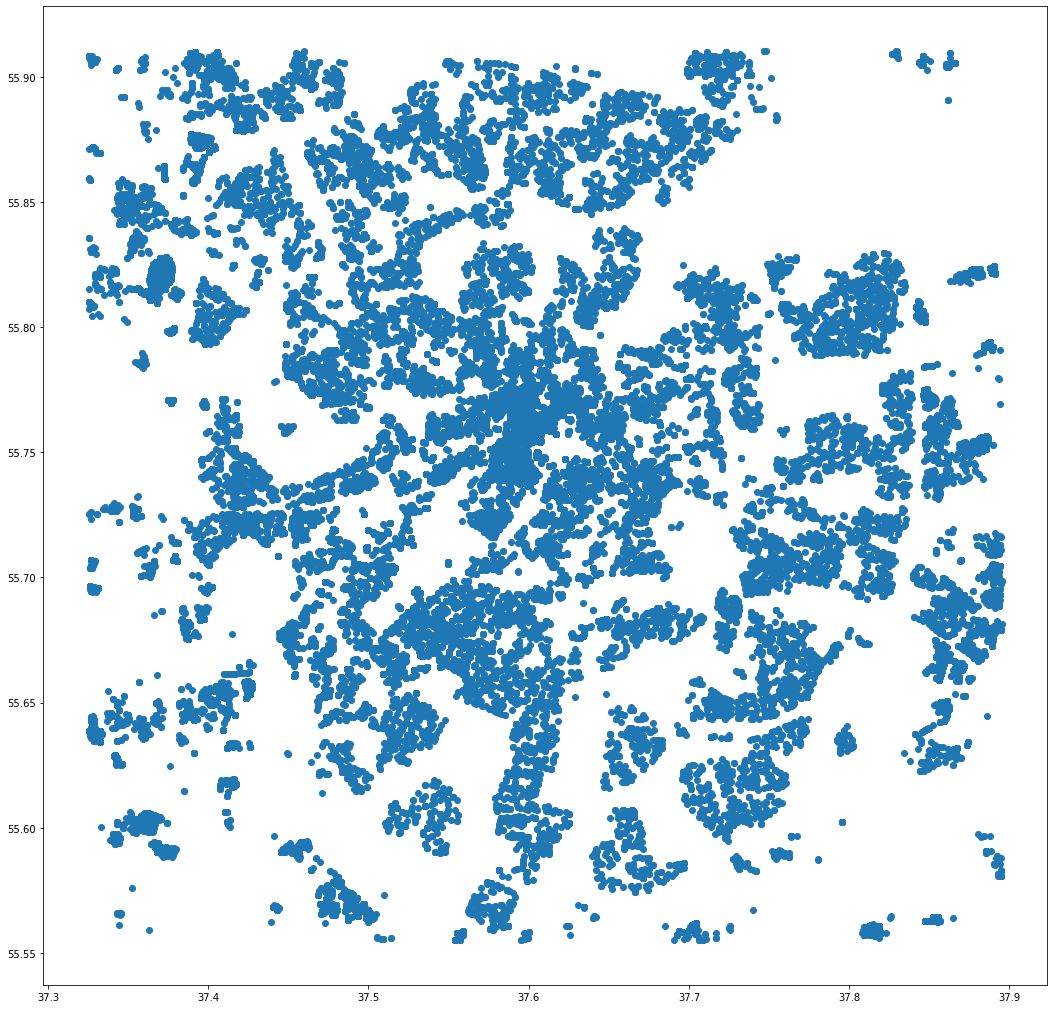

In [5]:
plt.rcParams["figure.figsize"] = (18,18)
plt.scatter(data.Long, data.Lat)

In [6]:
# Calculates the azimuth from two given points, the code is taken from here: https://pastebin.com/PHeWmiEN
def get_azimuth(latitude, longitude):
 
    rad = 6372795

    llat1 = city_center_coordinates[0]
    llong1 = city_center_coordinates[1]
    llat2 = latitude
    llong2 = longitude

    lat1 = llat1*math.pi/180.
    lat2 = llat2*math.pi/180.
    long1 = llong1*math.pi/180.
    long2 = llong2*math.pi/180.

    cl1 = math.cos(lat1)
    cl2 = math.cos(lat2)
    sl1 = math.sin(lat1)
    sl2 = math.sin(lat2)
    delta = long2 - long1
    cdelta = math.cos(delta)
    sdelta = math.sin(delta)

    y = math.sqrt(math.pow(cl2*sdelta,2)+math.pow(cl1*sl2-sl1*cl2*cdelta,2))
    x = sl1*sl2+cl1*cl2*cdelta
    ad = math.atan2(y,x)

    x = (cl1*sl2) - (sl1*cl2*cdelta)
    y = sdelta*cl2
    z = math.degrees(math.atan(-y/x))

    if (x < 0):
        z = z+180.

    z2 = (z+180.) % 360. - 180.
    z2 = - math.radians(z2)
    anglerad2 = z2 - ((2*math.pi)*math.floor((z2/(2*math.pi))) )
    angledeg = (anglerad2*180.)/math.pi
    
    return round(angledeg, 2)


In [7]:
# We set the latitude and longitude of the city center and calculate 
# the distance from the center and azimuth for each apartment
city_center_coordinates = [55.7522, 37.6156]
data['distance'] = list(map(lambda x, y: geodesic(city_center_coordinates, [x, y]).meters, data['Lat'], data['Long']))
data['azimuth'] = list(map(lambda x, y: get_azimuth(x, y), data['Lat'], data['Long']))

In [8]:
# Process the column with the total area
chars_to_remove = ["\xa0",'м²Общая']
for item in chars_to_remove:
    data.TotalArea = data.TotalArea.str.replace(item, ' ')
data.TotalArea = data.TotalArea.str.strip()
data.TotalArea = data.TotalArea.str.replace(",", ".")
data.TotalArea = data.TotalArea.str.replace(' ', '').astype(float)

In [9]:
# Number of rooms according to the content of the ad
def defNumOfRooms(df):
    if '-комн. квартира' in df.Title:
        return int(df.Title[0])
    elif '-комн. апартаменты' in df.Title:
        return int(df.Title[0])
    elif 'Многокомнатн' in df.Title:
        return 6
    else:
        return 1
data['NumOfRooms'] = data.apply(defNumOfRooms, axis=1)
data['NumOfRooms'].value_counts()

2    13315
3    13039
1    10495
4     4954
5     1906
6     1079
Name: NumOfRooms, dtype: int64

In [10]:
# Is there a metro within walking distance
data['WalkAccess'] = data.TimeToMetro.str.replace('транспорте', ' ')

def defWalkAccess(df):
    if 'пешком'in df.WalkAccess:
        return 'yes'
    else:
        return 'no'
data['WalkAccess'] = data.apply(defWalkAccess,axis=1)
data.WalkAccess.value_counts()

yes    33550
no     11238
Name: WalkAccess, dtype: int64

In [11]:
# Fill in the blanks
data['ConstructionYear'] = data['ConstructionYear'].fillna('empty')
data['Сonst/ComplYear'] = data['Сonst/ComplYear'].fillna('empty')

# We make the third column with the year of construction, in which there will be no gaps
def defConstrYear(df):
    if 'стр' in df.ConstructionYear:
        return df.ConstructionYear
    elif 'стр' in df['Сonst/ComplYear']:
        return df['Сonst/ComplYear']
    elif 'empty' in df.ConstructionYear and 'empty' in df['Сonst/ComplYear']:
        return '2021' # Ads without year of construction - new buildings 
    
data['ConstrYear'] = data.apply(defConstrYear,axis=1)
# Extracting numbers from a string
data['ConstrYear'] = data['ConstrYear'].str.extract('(\d+)').astype(float)

In [12]:
# Remove extra characters, spaces. Save as float
remove_chars = ["$","₽","€","\xa0"]
for char in remove_chars:
    data['SalePrice'] = data.Price.str.replace(char, '')
data.SalePrice = data.SalePrice.str[:-1]
data.SalePrice = data.SalePrice.astype(float)
data.SalePrice

<ipython-input-12-dfba26e81638>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['SalePrice'] = data.Price.str.replace(char, '')


0         8300000.0
1        15000000.0
2         8850000.0
3        10900000.0
4        12100000.0
            ...    
44783    11800000.0
44784    10800000.0
44785     7500000.0
44786     7000000.0
44787     4900000.0
Name: SalePrice, Length: 44788, dtype: float64

In [13]:
# Let's create a new feature and translate it briefly into latin
data = data[data.AccommodationType.notna()]
def defAccomType(df):
    if 'Апартаменты' in df.AccommodationType:
        return 'apartment'
    elif 'Пентхаус' in df.AccommodationType:
        return 'penthouse'
    else:
        return 'flat'
data['AccomType'] = data.apply(defAccomType,axis=1)
data.AccomType.value_counts()

flat         41155
apartment     2993
penthouse      636
Name: AccomType, dtype: int64

In [14]:
# New sign for repair
data.Renovation = data.Renovation.fillna(method = 'ffill')
def defRenovType(df):
    if 'Без ремонта' in df.Renovation:
        return 'bare'
    if 'Дизайнерский' in df.Renovation:
        return 'design'
    if 'Евроремонт' in df.Renovation:
        return 'euro'
    if 'Косметический'in df.Renovation:
        return 'light'
data['RenovType'] = data.apply(defRenovType,axis=1)
data.RenovType.value_counts()

light     13699
euro      11992
bare      10106
design     8987
Name: RenovType, dtype: int64

In [15]:
# Apartment floor and total number of floors

# Floor
data['FloorNum'] = data.Floor.str.split('из').str[0].astype(int)
# number of floors
data['FloorAmnt'] = data.Floor.str.split('из').str[1].str.strip().str.replace('Этаж', '').astype(int)

In [16]:
data.head()

,AnnouncementID,Title,Address,Lat,Long,MetroStations,TimeToMetro,TotalArea,ConstructionYear,Price,Floor,Сonst/ComplYear,AccommodationType,Layout,Balconies,Renovation,Bathroom,WindowView,HouseType,FloorType,Entrances,Elevators,Heating,Emergency,Parking,GarbageChute,distance,azimuth,NumOfRooms,WalkAccess,ConstrYear,SalePrice,AccomType,RenovType,FloorNum,FloorAmnt
0,249939881,"3-комн. квартира, 70 м²","['Москва, НАО (Новомосковский), Филимонковское...",55.5592,37.3631,"['Филатов Луг', 'Прокшино', 'Теплый Стан']","[' ⋅ 12 мин. на транспорте', ' ⋅ 14 мин. на ...",70.0,Год постройки1993,8 300 000 ₽,3 из 4Этаж,1993Построен,Тип жильяВторичка,ПланировкаИзолированная,Балкон/лоджия1 балкон,РемонтКосметический,Санузел1 раздельный,Вид из оконВо двор,Тип домаПанельный,Тип перекрытийЖелезобетонные,Подъезды3,NaN,ОтоплениеЦентральное,АварийностьНет,ПарковкаНаземная,NaN,26727.127294,216.53,3,no,1993.0,8300000.0,flat,light,3,4
1,248599206,"3-комн. квартира, 85 м²","['Москва, НАО (Новомосковский), Сосенское посе...",55.5558,37.5141,"['Улица Горчакова', 'Бунинская аллея', 'Бульва...","[' ⋅ 32 мин. пешком', ' ⋅ 30 мин. пешком', '...",85.0,empty,15 000 000 ₽,6 из 14Этаж,2019Построен,Тип жильяВторичка,NaN,Балкон/лоджия1 балкон,РемонтЕвроремонт,Санузел2 раздельных,Вид из оконВо двор,Тип домаМонолитный,NaN,NaN,"Лифты1 пасс., 1 груз.",NaN,NaN,NaN,МусоропроводЕсть,22780.652896,196.30,3,yes,2019.0,15000000.0,flat,euro,6,14
2,249413858,"1-комн. квартира, 43,2 м²","['Москва, НАО (Новомосковский), Сосенское посе...",55.5561,37.5054,"['Улица Горчакова', 'Бунинская аллея', 'Коммун...","[' ⋅ 8 мин. на транспорте', ' ⋅ 9 мин. на тр...",43.2,empty,8 850 000 ₽,10 из 16Этаж,empty,Тип жильяВторичка,NaN,Балкон/лоджия1 лоджия,РемонтБез ремонта,Санузел1 совмещенный,Вид из оконВо двор,NaN,NaN,NaN,"Лифты2 пасс., 1 груз.",NaN,NaN,ПарковкаПодземная,NaN,22908.435320,197.64,1,no,2021.0,8850000.0,flat,bare,10,16
3,250938333,"2-комн. квартира, 57 м²","['Москва, НАО (Новомосковский), Сосенское посе...",55.5558,37.5141,"['Бунинская аллея', 'Бунинская аллея']",[' ⋅ 20 мин. пешком'],57.0,empty,10 900 000 ₽,6 из 12Этаж,2020Построен,Тип жильяВторичка,NaN,Балкон/лоджия1 балкон,РемонтБез ремонта,Санузел1 раздельный,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22780.652896,196.30,2,yes,2020.0,10900000.0,flat,bare,6,12
4,249969831,"1-комн. квартира, 53 м²","['Москва, ЮЗАО, р-н Южное Бутово, ул. Поляны, ...",55.5578,37.5550,[],[],53.0,Год постройки2018,12 100 000 ₽,8 из 31Этаж,empty,Тип жильяВторичка,NaN,NaN,РемонтБез ремонта,NaN,Вид из оконВо двор,Тип домаМонолитный,Тип перекрытийЖелезобетонные,Подъезды6,Лифты18 всего,ОтоплениеЦентральное,АварийностьНет,NaN,NaN,21977.212660,190.00,1,no,2018.0,12100000.0,flat,bare,8,31


In [17]:
# Function for counting missing columns
def missing_values_table(df):
    
        # Missing at all
        mis_val = df.isnull().sum()
        
        # Missing percentage
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Result table
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Renamed columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sorting 
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Info
        print (f'{str(df.shape[1])} columns at all \
        \n{str(mis_val_table_ren_columns.shape[0])} columns with missing values')
    
        return mis_val_table_ren_columns
    
missing_values = missing_values_table(data)
missing_values.head(15)

36 columns at all         
12 columns with missing values


,Missing Values,% of Total Values
Parking,28019,62.6
Layout,24126,53.9
GarbageChute,21629,48.3
Balconies,17058,38.1
FloorType,11999,26.8
WindowView,11579,25.9
Heating,11145,24.9
Entrances,9492,21.2
Emergency,6916,15.4
HouseType,6179,13.8


In [18]:
# Remove gaps and unnecessary columns and save in df
clean_data = data.dropna(axis=1)
clean_data = clean_data.drop(['Title','Address','MetroStations','TimeToMetro',
                      'ConstructionYear','Price','Floor','Сonst/ComplYear','AccommodationType','Renovation'],axis=1)
clean_data.to_csv('clean_cian_data.csv',index=False)

In [19]:
clean_data = pd.read_csv('clean_cian_data.csv')

<AxesSubplot:>

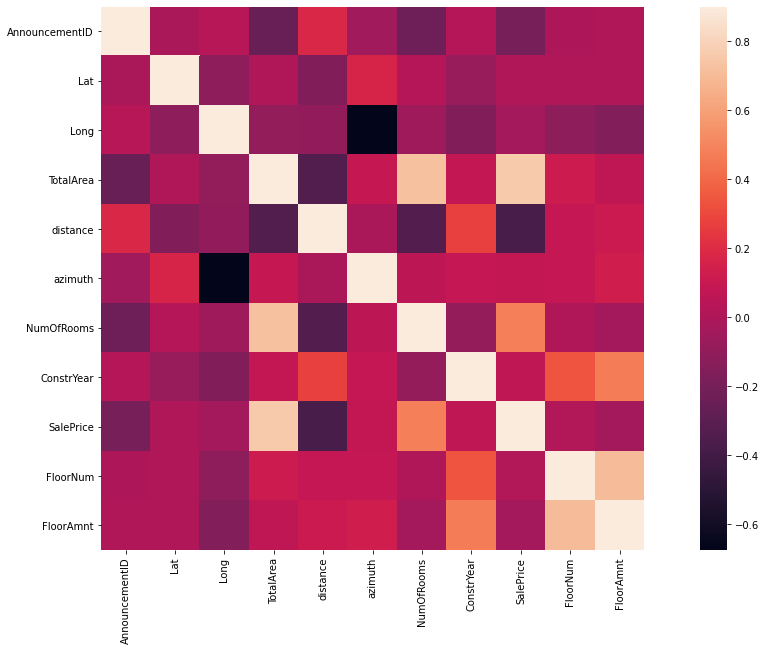

In [20]:
#  Multicollinearity check
corrmat = clean_data.corr()
plt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, vmax=.9, square=True)

In [21]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44784 entries, 0 to 44783
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AnnouncementID  44784 non-null  int64  
 1   Lat             44784 non-null  float64
 2   Long            44784 non-null  float64
 3   TotalArea       44784 non-null  float64
 4   distance        44784 non-null  float64
 5   azimuth         44784 non-null  float64
 6   NumOfRooms      44784 non-null  int64  
 7   WalkAccess      44784 non-null  object 
 8   ConstrYear      44784 non-null  float64
 9   SalePrice       44784 non-null  float64
 10  AccomType       44784 non-null  object 
 11  RenovType       44784 non-null  object 
 12  FloorNum        44784 non-null  int64  
 13  FloorAmnt       44784 non-null  int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 4.3+ MB


In [22]:
# training data and target 
X = clean_data.drop(['SalePrice','AnnouncementID'],axis=1)
y = clean_data.SalePrice

# Data retraining pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
pipe = Pipeline(steps=[('preprocessor', preprocessor)])
prod_pipe = pipe.fit(X)
# transform train
transformed_data = prod_pipe.fit_transform(X)

In [23]:
import sklearn
import warnings
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [25]:
column_names = get_feature_names(preprocessor)
transformed_df = pd.DataFrame(transformed_data, columns=column_names)
transformed_df.head()

<ipython-input-23-6e88926344ab>:32: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-23-6e88926344ab>:32: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


,num__Lat,num__Long,num__TotalArea,num__distance,num__azimuth,num__NumOfRooms,num__ConstrYear,num__FloorNum,num__FloorAmnt,onehot__x0_no,onehot__x0_yes,onehot__x1_apartment,onehot__x1_flat,onehot__x1_penthouse,onehot__x2_bare,onehot__x2_design,onehot__x2_euro,onehot__x2_light
0,-2.300318,-1.674858,-0.251867,2.626738,0.111598,0.408682,0.026685,-0.700506,-1.085286,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-2.342724,-0.533193,-0.052228,1.975956,-0.097031,0.408682,0.927748,-0.290506,-0.148619,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-2.338982,-0.598971,-0.608556,1.997028,-0.083211,-1.232938,0.997061,0.256162,0.038714,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-2.342724,-0.533193,-0.424888,1.975956,-0.097031,-0.412128,0.962405,-0.290506,-0.335953,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-2.317779,-0.223960,-0.478125,1.843467,-0.162001,-1.232938,0.893092,-0.017172,1.443714,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


c:\users\78904\pycharmprojects\pet-project\.venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


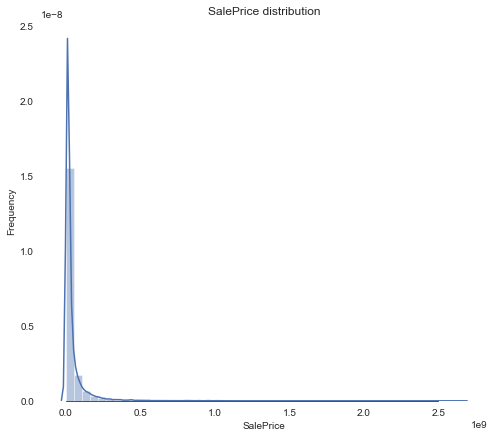

In [33]:
# Target distribution 
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(y, color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [34]:
# logarithm the target feature
log_target= np.log1p(y)

c:\users\78904\pycharmprojects\pet-project\.venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 16.87 and sigma = 1.00



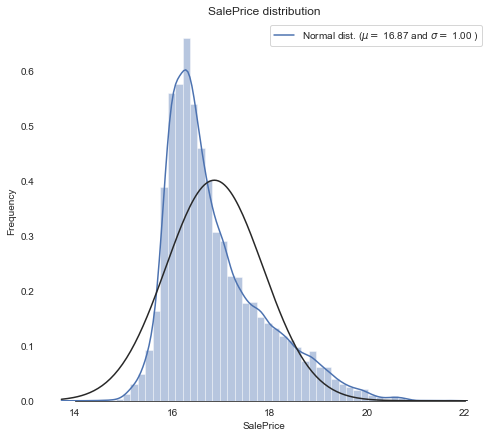

In [35]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(log_target , fit=norm, color="b");

# Compared to normal
(mu, sigma) = norm.fit(log_target)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# New feature distrbution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

### Step 2 Training and predicting

In [47]:
# XGBoost Regressor
xgb_reg_model = xgb.XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       n_jobs=-1,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

In [48]:
# Train test spliting and separate saving AnnouncementID to compare with the prices on the website
transformed_df['AnnouncementID'] = clean_data['AnnouncementID']
X_train, X_test = train_test_split(
    transformed_df, train_size=0.7, shuffle=True, random_state=1,
)
y_train, y_test = train_test_split(
    log_target, train_size=0.7, shuffle=True, random_state=1,
)

kfold = KFold(n_splits=10, shuffle=True, random_state=27)

def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X, y_train, scoring="neg_mean_squared_error", cv=kfold))
    return (rmse)

score = cv_rmse(xgb_reg_model)

print(f"CV-results: {round(score.mean(), 4)} +/- {round(score.std(), 3)}")

CV-results: 0.1778 +/- 0.003


In [49]:
# Training and prediction
xgb_reg_model = xgb_reg_model.fit(X_train, y_train)
y_pred = xgb_reg_model.predict(X_test)

In [51]:
# Root Mean Squared Log Error
def rmsle(y_train, y_pred):
    return np.sqrt(mean_squared_error(y_train, y_pred))
norm_valid = np.floor(np.expm1(y_test))
norm_pred = np.floor(np.expm1(y_pred))

# Metrics on baseline 
print(f'RMSLE: {rmsle(y_test,y_pred)}')
print(f'RMSE: {mean_squared_error(norm_valid,norm_pred, squared = False)}')
print(f'MAPE: {mean_absolute_percentage_error(norm_valid, norm_pred)}')
print(f'R2: {r2_score(norm_valid, norm_pred)}')

delta = score.mean() - rmsle(y_test,y_pred)
print(f"Delta between CV-score and OOF-score: {round(delta, 4)}")

RMSLE: 0.17303796188349924
RMSE: 25154295.692161668
MAPE: 0.12558286705739538
R2: 0.907271130811662
Delta between CV-score and OOF-score: 0.0048


In [35]:
result_df = pd.DataFrame(X_test, columns=column_names)
result_df['AnnouncementID'] = test_id
result_df['PredPrice'] = norm_pred
result_df.head(10)

,num__Lat,num__Long,num__TotalArea,num__distance,num__azimuth,num__NumOfRooms,num__ConstrYear,num__FloorNum,num__FloorAmnt,onehot__x0_no,onehot__x0_yes,onehot__x1_apartment,onehot__x1_flat,onehot__x1_penthouse,onehot__x2_bare,onehot__x2_design,onehot__x2_euro,onehot__x2_light,AnnouncementID,PredPrice
1864,-1.896220,-1.044296,-0.225249,1.650448,0.052196,-0.412128,0.962405,0.529495,0.038714,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,248318256,13061374.0
40433,1.460045,-0.297299,-0.681757,0.339912,1.385132,-0.412128,0.997061,-0.563839,-0.148619,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,248535927,10924224.0
3541,-1.538268,1.327495,-0.665786,1.067815,-0.592872,-1.232938,-0.215909,-0.837173,-0.148619,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,245880906,8029163.0
38563,1.090868,-0.096941,-0.597909,-0.262829,1.412667,-0.412128,-0.770410,-0.427172,-0.616953,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,250893034,10214865.0
25577,0.215321,-0.260252,0.928533,-1.084932,0.800497,1.229492,0.858436,-0.017172,-0.242286,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,249670257,113525152.0
29442,0.394920,-0.434148,-0.611218,-0.772054,0.920332,-1.232938,0.962405,1.212830,0.788047,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,249900238,15601440.0
3931,-1.402321,0.626618,-0.591254,0.505158,-0.405488,-0.412128,-0.943691,-0.563839,-0.335953,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,250413778,9317929.0
33217,0.613184,2.263509,-0.052228,1.095342,-1.349629,0.408682,0.719811,-0.153839,0.881714,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,248989613,11852955.0
28600,0.302626,0.104930,0.546689,-1.442353,1.266431,1.229492,-3.127038,-0.017172,-0.616953,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,248733029,61598712.0
31978,0.518395,-0.183133,-0.202623,-0.947859,1.145255,-0.412128,0.997061,-0.563839,0.507047,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,231006966,25607096.0


In [ ]:
# Train test spliting and separate saving AnnouncementID to compare with the prices on the website
transformed_df['AnnouncementID'] = clean_data['AnnouncementID']
X_train, X_test, y_train, y_test = train_test_split(transformed_df, log_target, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
train_id = X_train.AnnouncementID
X_train = X_train.drop('AnnouncementID',axis=1)
test_id = X_test.AnnouncementID
X_test = X_test.drop('AnnouncementID',axis=1)

In [14]:
# Now let's do a grid search for parameters

xgb_reg_model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 n_jobs=-1,
                 seed=42)

params = {
        'min_child_weight': [0, 1, 2],
        'gamma': [0.3, 0.5],
        'subsample': [0.6, 0.7],
        'colsample_bytree': [0.6,0.7],
        'max_depth': [3, 4],
        'reg_alpha':[1e-5, 1e-2],
       'reg_lambda':[1e-5, 1e-2],
       'learning_rate':[0.1,0.07]
        }

random_search = RandomizedSearchCV(
            estimator=xgb_reg_model,
            param_distributions=params,
            cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

In [15]:
dt_start = datetime.now()
random_search_result = random_search.fit(X_train, y_train)
print(f'Ended in {str(datetime.now() - dt_start)}')

Ended in 0:35:16.067460


In [16]:
# Getting and saving best model and pipeline
XGB_best_reg = random_search_result.best_estimator_
XGB_best_reg.save_model('XGB_best_reg.json')

pipe_filename = 'prod_pipeline_file'
joblib.dump(prod_pipe, pipe_filename)

['prod_pipeline_file']

In [13]:
# Load and check pipeline and model
prod_pipe = joblib.load('prod_pipeline_file')
XGB_best_reg = xgb.XGBRegressor()
XGB_best_reg.load_model('XGB_best_reg.json')

In [16]:
# prediction
y_pred = XGB_best_reg.predict(X_test)

# Root Mean Squared Log Error
def rmsle(y_train, y_pred):
    return np.sqrt(mean_squared_error(y_train, y_pred))
norm_valid = np.floor(np.expm1(y_test))
norm_pred = np.floor(np.expm1(y_pred))

# Metrics on baseline 
print(f'RMSLE: {rmsle(y_test,y_pred)}')
print(f'RMSE: {mean_squared_error(norm_valid,norm_pred, squared = False)}')
print(f'MAPE: {mean_absolute_percentage_error(norm_valid, norm_pred)}')
print(f'R2: {r2_score(norm_valid, norm_pred)}')

RMSLE: 0.15794097838194174
RMSE: 23848052.090705737
MAPE: 0.11091079452003162
R2: 0.9197132666927573


In [18]:
result_df = pd.DataFrame(X_test, columns=column_names)
result_df['AnnouncementID'] = test_id
result_df['PredPrice'] = norm_pred
result_df.head(10)

,num__Lat,num__Long,num__TotalArea,num__distance,num__azimuth,num__NumOfRooms,num__ConstrYear,num__FloorNum,num__FloorAmnt,onehot__x0_no,onehot__x0_yes,onehot__x1_apartment,onehot__x1_flat,onehot__x1_penthouse,onehot__x2_bare,onehot__x2_design,onehot__x2_euro,onehot__x2_light,AnnouncementID,PredPrice
1864,-1.896220,-1.044296,-0.225249,1.650448,0.052196,-0.412128,0.962405,0.529495,0.038714,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,248318256,12452035.0
40433,1.460045,-0.297299,-0.681757,0.339912,1.385132,-0.412128,0.997061,-0.563839,-0.148619,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,248535927,10526102.0
3541,-1.538268,1.327495,-0.665786,1.067815,-0.592872,-1.232938,-0.215909,-0.837173,-0.148619,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,245880906,8102029.0
38563,1.090868,-0.096941,-0.597909,-0.262829,1.412667,-0.412128,-0.770410,-0.427172,-0.616953,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,250893034,10127160.0
25577,0.215321,-0.260252,0.928533,-1.084932,0.800497,1.229492,0.858436,-0.017172,-0.242286,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,249670257,113649072.0
29442,0.394920,-0.434148,-0.611218,-0.772054,0.920332,-1.232938,0.962405,1.212830,0.788047,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,249900238,16614617.0
3931,-1.402321,0.626618,-0.591254,0.505158,-0.405488,-0.412128,-0.943691,-0.563839,-0.335953,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,250413778,9197733.0
33217,0.613184,2.263509,-0.052228,1.095342,-1.349629,0.408682,0.719811,-0.153839,0.881714,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,248989613,12033574.0
28600,0.302626,0.104930,0.546689,-1.442353,1.266431,1.229492,-3.127038,-0.017172,-0.616953,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,248733029,55160308.0
31978,0.518395,-0.183133,-0.202623,-0.947859,1.145255,-0.412128,0.997061,-0.563839,0.507047,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,231006966,26039440.0
